In [1]:
from pathlib import Path

paths = list(Path("../data/raw/ESA_WorldCover_10m_2020_v100_Map").glob("*/*.tif"))
paths[:3]

[PosixPath('../data/raw/ESA_WorldCover_10m_2020_v100_Map/3deg_cogs/ESA_WorldCover_10m_2020_v100_N00E006_Map.tif'),
 PosixPath('../data/raw/ESA_WorldCover_10m_2020_v100_Map/3deg_cogs/ESA_WorldCover_10m_2020_v100_N00E009_Map.tif'),
 PosixPath('../data/raw/ESA_WorldCover_10m_2020_v100_Map/3deg_cogs/ESA_WorldCover_10m_2020_v100_N00E012_Map.tif')]

In [8]:
import rioxarray as rxr
import xarray as xr
import dask


@dask.delayed
def lazy_open(href):
    chunks = dict(band=1, x=2745, y=2745)
    return rxr.open_rasterio(href, chunks=chunks)


data_arrays = dask.compute(*[lazy_open(p) for p in paths[:5]])
da = xr.concat(data_arrays, dim="band", join="override", combine_attrs="drop")

In [16]:
data_arrays[0]

,Array,Chunk
Bytes,1.21 GiB,7.19 MiB
Shape,"(1, 36000, 36000)","(1, 2745, 2745)"
Count,2 Graph Layers,196 Chunks
Type,uint8,numpy.ndarray


In [4]:
da.mean(dim=["x", "y"]).compute()

<xarray.DataArray (class: 5)>
array([ 9.55973613, 19.71191264, 10.21316259, 11.06706458, 12.48972471])
Coordinates:
  * class        (class) int64 1 1 1 1 1
    spatial_ref  int64 0

In [48]:
da.plot.hist()

: 

: 

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


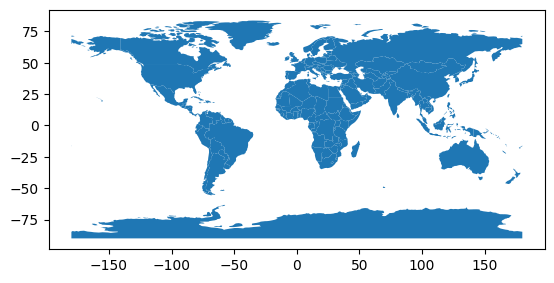

In [5]:
from geocube.api.core import make_geocube
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world["continent"] = world.continent.astype("category")
world.plot()
world.head()

In [19]:
out_grid = make_geocube(vector_data=world, like=da)
out_grid

In [ ]:
out_grid.mean()

<xarray.Dataset>
Dimensions:               (y: 36000, x: 36000, continent_categories: 8)
Coordinates:
  * y                     (y) float64 3.0 3.0 3.0 ... 0.000125 4.167e-05
  * x                     (x) float64 6.0 6.0 6.0 6.0 6.0 ... 9.0 9.0 9.0 9.0
  * continent_categories  (continent_categories) object 'Africa' ... 'South A...
    spatial_ref           int64 0
Data variables:
    continent             (y, x) int16 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1